In [14]:
global using_COLAB
global should_show_videos
using_COLAB = False
should_show_videos = False

if using_COLAB:
    !pip install gym
import random
import torch
import numpy as np
import gym
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from torch import nn
from collections import deque # this python module implements exactly what we need for the replay memory

if using_COLAB:
    !apt update
    !apt-get install python-opengl -y
    !apt install xvfb -y
    !pip install pyvirtualdisplay
    !pip install piglet
import glob
import io
import base64
import os
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import Monitor

# Set random seeds
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

if using_COLAB:
    display = Display(visible=0, size=(1400, 900))
    display.start()
    # This code creates a virtual display to draw game images on. 
    # If you are running locally, just ignore it
    if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
        !bash ../xvfb start
        %env DISPLAY=:1

"""
Utility functions to enable video recording of gym environment and displaying it on Colab
To enable video, just do "env = wrap_env(env)""
"""
def show_videos():
  global using_COLAB
  global should_show_videos
  if using_COLAB is False or should_show_videos is False:
    return
  mp4list = glob.glob('video/*.mp4')
  mp4list.sort()
  for mp4 in mp4list:
    print(f"\nSHOWING VIDEO {mp4}")
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
            </video>'''.format(encoded.decode('ascii'))))
    
def wrap_env(env, video_callable=None):
  global using_COLAB
  global should_show_videos
  if using_COLAB is False or should_show_videos is False:
    return env
  env = Monitor(env, './video', force=True, video_callable=video_callable)
  return env

## Replay Memory

In [15]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity) # Define a queue with maxlen "capacity"

    def push(self, state, action, next_state, reward):
        # [Done] TODO: Add the tuple (state, action, next_state, reward) to the queue
        self.memory.append((state, action, next_state, reward))

    def sample(self, batch_size):
        batch_size = min(batch_size, len(self)) # Get all the samples if the requested batch_size is higher than the number of sample currently in the memory
        return random.sample(self.memory, batch_size) # Randomly select "batch_size" samples

    def __len__(self):
        return len(self.memory) # Return the number of samples currently stored in the memory

    def test():
        # Test if it works as expected.
        # Define the replay memory
        replay_mem = ReplayMemory(capacity=3)

        # Push some samples
        print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
        replay_mem.push(1,1,1,1)
        print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
        replay_mem.push(2,2,2,2)
        print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
        replay_mem.push(3,3,3,3)
        print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
        replay_mem.push(4,4,4,4)
        print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
        replay_mem.push(5,5,5,5)
        print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")

        # Check the content of the memory
        print('\nCONTENT OF THE MEMORY')
        print(replay_mem.memory)

        # Random sample
        print('\nRANDOM SAMPLING')
        for i in range(5):
            print(replay_mem.sample(2)) # Select 2 samples randomly from the memory

ReplayMemory.test()

CURRENT MEMORY SIZE: 0
CURRENT MEMORY SIZE: 1
CURRENT MEMORY SIZE: 2
CURRENT MEMORY SIZE: 3
CURRENT MEMORY SIZE: 3
CURRENT MEMORY SIZE: 3

CONTENT OF THE MEMORY
deque([(3, 3, 3, 3), (4, 4, 4, 4), (5, 5, 5, 5)], maxlen=3)

RANDOM SAMPLING
[(4, 4, 4, 4), (5, 5, 5, 5)]
[(3, 3, 3, 3), (4, 4, 4, 4)]
[(5, 5, 5, 5), (4, 4, 4, 4)]
[(4, 4, 4, 4), (5, 5, 5, 5)]
[(4, 4, 4, 4), (5, 5, 5, 5)]


## Network definition, Exploration Policy, Exploration profile and Network Update

In [16]:
class DeepQNetwork(nn.Module):

    def __init__(self, state_space_dim, action_space_dim, params):
        super().__init__()

        self.params = params

        self.linear = nn.Sequential(
            nn.Linear(state_space_dim, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, action_space_dim)
        )

    def forward(self, x):
        return self.linear(x)

    def get_gym_info(gym_environment_name):
        ### Create environment
        env = gym.make(gym_environment_name) # Initialize the Gym environment
        env.seed(0) # Set a random seed for the environment (reproducible results)
        env = wrap_env(env, video_callable=lambda episode_id: episode_id % 100 == 0) # Save a video every 100 episodes
        
        # Get the shapes of the state space (observation_space) and action space (action_space)
        state_space_dim = env.observation_space.shape[0]
        action_space_dim = env.action_space.n

        print(f"STATE SPACE SIZE: {state_space_dim}")
        print(f"ACTION SPACE SIZE: {action_space_dim}")
        return env, state_space_dim, action_space_dim

    def choose_action_epsilon_greedy(net, state, epsilon):
        if epsilon > 1 or epsilon < 0:
            raise Exception('The epsilon value must be between 0 and 1')
        
        with torch.no_grad(): # Evaluate the network output from the current state
            net.eval()
            state = torch.tensor(state, dtype=torch.float32) # Convert the state to tensor
            net_out = net(state)

        best_action = int(net_out.argmax()) # Get the best action (argmax of the network output)
        action_space_dim = net_out.shape[-1] # Get the number of possible actions

        if random.random() < epsilon: # Select a non optimal action with probability epsilon, otherwise choose the best action
            non_optimal_actions = [action_index for action_index in range(action_space_dim) if action_index != best_action] # List of non-optimal actions
            action = random.choice(non_optimal_actions) # Select randomly
        else:
            action = best_action # Select best action
            
        return action, net_out.numpy()

    def choose_action_softmax(net, state, temperature):
        if temperature < 0:
            raise Exception('The temperature value must be greater than or equal to 0 ')
        
        if temperature == 0: # If the temperature is 0, just select the best action using the eps-greedy policy with epsilon = 0
            return DeepQNetwork.choose_action_epsilon_greedy(net, state, 0)
        
        with torch.no_grad(): # Evaluate the network output from the current state
            net.eval()
            state = torch.tensor(state, dtype=torch.float32)
            net_out = net(state)

        temperature = max(temperature, 1e-8) # Apply softmax with temp. Set a minimum to the temperature for numerical stability
        softmax_out = nn.functional.softmax(net_out / temperature, dim=0).numpy()
        
        all_possible_actions = np.arange(0, softmax_out.shape[-1]) # Sample the action using softmax output as mass pdf
        action = np.random.choice(all_possible_actions, p=softmax_out) # this samples a random element from "all_possible_actions" with the probability distribution p (softmax_out in this case)
        
        return action, net_out.numpy()

    def get_exploration_profile(params):
        initial_value = params['exploration_profile__initial_temperature_value'] #5
        num_iterations = params['exploration_profile__num_iterations']#1000
        exp_decay = np.exp(-np.log(initial_value) / num_iterations * 6) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
        exploration_profile = [initial_value * (exp_decay ** i) for i in range(num_iterations)]
        return exploration_profile

    def update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size):
        
        # Sample the data from the replay memory
        batch = replay_mem.sample(batch_size)
        batch_size = len(batch)

        # Create tensors for each element of the batch
        states      = torch.tensor([s[0] for s in batch], dtype=torch.float32)
        actions     = torch.tensor([s[1] for s in batch], dtype=torch.int64)
        rewards     = torch.tensor([s[3] for s in batch], dtype=torch.float32)

        # Compute a mask of non-final states (all the elements where the next state is not None)
        non_final_next_states = torch.tensor([s[2] for s in batch if s[2] is not None], dtype=torch.float32) # the next state can be None if the game has ended
        non_final_mask = torch.tensor([s[2] is not None for s in batch], dtype=torch.bool)

        # Compute all the Q values (forward pass)
        policy_net.train()
        q_values = policy_net(states)
        # Select the proper Q value for the corresponding action taken Q(s_t, a)
        state_action_values = q_values.gather(1, actions.unsqueeze(1))

        # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
        with torch.no_grad():
            target_net.eval()
            q_values_target = target_net(non_final_next_states)
        next_state_max_q_values = torch.zeros(batch_size)
        next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0]

        # Compute the expected Q values
        expected_state_action_values = rewards + (next_state_max_q_values * gamma)
        expected_state_action_values = expected_state_action_values.unsqueeze(1) # Set the required tensor shape

        # Compute the Huber loss
        loss = loss_fn(state_action_values, expected_state_action_values)

        # Optimize the model
        optimizer.zero_grad()
        loss.backward()
        # Apply gradient clipping (clip all the gradients greater than 2 for training stability)
        nn.utils.clip_grad_norm_(policy_net.parameters(), 2)
        optimizer.step()

# Gym Environment (CartPole-v1)
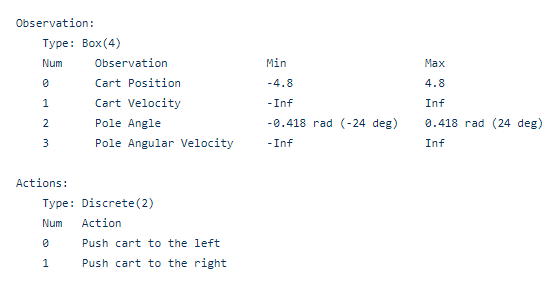

In [17]:
class CartPoleRunner:
    def run_cartpole(params):
        gym_environment_name = params['gym_environment_name']
        gamma = params['gamma']
        replay_memory_capacity = params['replay_memory_capacity']
        lr = params['lr']
        target_net_update_steps = params['target_net_update_steps']
        batch_size = params['batch_size']
        bad_state_penalty = params['bad_state_penalty']
        min_samples_for_training = params['min_samples_for_training']
        reward_function = params['reward_function']
        
        replay_mem = ReplayMemory(replay_memory_capacity) # Initialize the replay memory
        env, state_space_dim, action_space_dim = DeepQNetwork.get_gym_info(gym_environment_name) # Initialize the Gym environment
        policy_net = DeepQNetwork(state_space_dim, action_space_dim, params) # Initialize the policy network
        target_net = DeepQNetwork(state_space_dim, action_space_dim, params) # Initialize the target network with the same weights of the policy network
        target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

        optimizer = torch.optim.SGD(policy_net.parameters(), lr=lr) # Initialize the optimizer. The optimizer will update ONLY the parameters of the policy network

        loss_fn = nn.SmoothL1Loss() # Initialize the loss function (Huber loss)

        exploration_profile = DeepQNetwork.get_exploration_profile(params)

        maximum_score = float('-inf')
        episode_maximum_score = float('-inf')
        temperature_maximum_score = float('-inf')

        for episode_num, tau in enumerate(tqdm(exploration_profile)):
            state = env.reset() # Reset the environment and get the initial state
            score = 0 # Reset the score. The final score will be the total amount of steps before the pole falls
            done = False

            while not done: # Go on until the pole falls off
                action, q_values = DeepQNetwork.choose_action_softmax(policy_net, state, temperature=tau) # Choose the action following the policy
                next_state, reward, done, info = env.step(action) # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
                #pos_weight = pos_weight_multiplier # We apply a (linear) penalty when the cart is far from center
                #reward = reward - pos_weight * np.abs(state[0]) 
                reward = reward_function(reward, state)

                score += 1 # Update the final score (+1 for each step)

                # Apply penalty for bad state
                if done: # if the pole has fallen down 
                    reward += bad_state_penalty
                    next_state = None

                # Update the replay memory
                replay_mem.push(state, action, next_state, reward)

                # Update the network
                if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
                    DeepQNetwork.update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)

                if should_show_videos:
                    env.render() # Visually render the environment (disable to speed up the training)
                
                state = next_state # Set the current state for the next iteration

            if episode_num % target_net_update_steps == 0: # Update the target network every target_net_update_steps episodes
                print('Updating target network...')
                target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

            print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score
            
            if score > maximum_score:
                maximum_score = score
                episode_maximum_score = episode_num
                temperature_maximum_score = tau
        env.close()
        print(f"(Best) EPISODE: {episode_maximum_score} - FINAL SCORE: {maximum_score} - Temperature: {temperature_maximum_score}") # Print the final score
        return policy_net
    
    def validate_trained_model(policy_net, number_of_validation_episodes = 10):
        gym_environment_name = policy_net.params['gym_environment_name']
        env, _, _ = DeepQNetwork.get_gym_info(gym_environment_name) # Initialize the Gym environment

        for num_episode in range(number_of_validation_episodes):
            state = env.reset() # Reset the environment and get the initial state
            score = 0 # Reset the score. The final score will be the total amount of steps before the pole falls
            done = False
            
            while not done: # Go on until the pole falls off
                action, q_values = DeepQNetwork.choose_action_softmax(policy_net, state, temperature=0) # Choose the best action (temperature 0)
                next_state, reward, done, info = env.step(action) # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
                if should_show_videos:
                    env.render() # Visually render the environment
                
                score += reward # Update the final score (+1 for each step)
                state = next_state # Set the current state for the next iteration
                
            # Print the final score
            print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
        env.close()

In [18]:
### PARAMETERS (From Lab07)
pos_weight = 1
params = {
    'gym_environment_name': 'CartPole-v1',
    'gamma': 0.97,   # gamma parameter for the long term reward
    'replay_memory_capacity': 10000,   # Replay memory capacity
    'min_samples_for_training': 1000,   # Minimum samples in the replay memory to enable the training
    'lr': 1e-2,   # Optimizer learning rate
    'target_net_update_steps': 10,   # Number of episodes to wait before updating the target network
    'batch_size': 128,   # Number of samples to take from the replay memory for each update
    'bad_state_penalty': 0,   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
    'exploration_profile__initial_temperature_value': 5,
    'exploration_profile__num_iterations': 1000,
    'reward_function': lambda reward, state: reward - pos_weight * np.abs(state[0]) 
}
policy_net = CartPoleRunner.run_cartpole(params)

STATE SPACE SIZE: 4
ACTION SPACE SIZE: 2


  0%|          | 0/1000 [00:00<?, ?it/s]

Updating target network...
EPISODE: 1 - FINAL SCORE: 12 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: 17 - Temperature: 4.951949240166454
EPISODE: 3 - FINAL SCORE: 41 - Temperature: 4.904360255437024
EPISODE: 4 - FINAL SCORE: 19 - Temperature: 4.857228608082785
EPISODE: 5 - FINAL SCORE: 24 - Temperature: 4.810549903022062
EPISODE: 6 - FINAL SCORE: 16 - Temperature: 4.764319787410582
EPISODE: 7 - FINAL SCORE: 30 - Temperature: 4.7185339502355665
EPISODE: 8 - FINAL SCORE: 29 - Temperature: 4.673188121913726
EPISODE: 9 - FINAL SCORE: 15 - Temperature: 4.628278073893115
EPISODE: 10 - FINAL SCORE: 21 - Temperature: 4.583799618258813
Updating target network...
EPISODE: 11 - FINAL SCORE: 31 - Temperature: 4.5397486073424025
EPISODE: 12 - FINAL SCORE: 59 - Temperature: 4.4961209333351855
EPISODE: 13 - FINAL SCORE: 29 - Temperature: 4.452912527905132
EPISODE: 14 - FINAL SCORE: 26 - Temperature: 4.4101193618175
EPISODE: 15 - FINAL SCORE: 18 - Temperature: 4.367737444559107
EPISODE: 16 - FINAL SCO

In [19]:
should_show_videos = True
CartPoleRunner.validate_trained_model(policy_net, number_of_validation_episodes=10)
show_videos() # Display the videos, not required outside Colab
should_show_videos = False

STATE SPACE SIZE: 4
ACTION SPACE SIZE: 2
EPISODE 1 - FINAL SCORE: 500.0
EPISODE 2 - FINAL SCORE: 500.0
EPISODE 3 - FINAL SCORE: 392.0
EPISODE 4 - FINAL SCORE: 322.0
EPISODE 5 - FINAL SCORE: 500.0
EPISODE 6 - FINAL SCORE: 500.0
EPISODE 7 - FINAL SCORE: 310.0
EPISODE 8 - FINAL SCORE: 439.0
EPISODE 9 - FINAL SCORE: 500.0
EPISODE 10 - FINAL SCORE: 500.0


In [20]:
### PARAMETERS (From Lab07 - Tuned parameters and Tweaked reward function)
params = {
    'gym_environment_name': 'CartPole-v1',
    'gamma': 0.97,   # gamma parameter for the long term reward
    'replay_memory_capacity': 10000,   # Replay memory capacity
    'min_samples_for_training': 1000,   # Minimum samples in the replay memory to enable the training
    'lr': 2e-2,   # Optimizer learning rate
    'target_net_update_steps': 5,   # Number of episodes to wait before updating the target network
    'batch_size': 64,   # Number of samples to take from the replay memory for each update
    'bad_state_penalty': 0,   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
    'exploration_profile__initial_temperature_value': 7,
    'exploration_profile__num_iterations': 400,
    'reward_function': lambda reward, state: reward - (np.abs(state[0]) + np.abs(state[2])*2)
}
policy_net = CartPoleRunner.run_cartpole(params)

STATE SPACE SIZE: 4
ACTION SPACE SIZE: 2


  0%|          | 0/400 [00:00<?, ?it/s]

Updating target network...
EPISODE: 1 - FINAL SCORE: 17 - Temperature: 7.0
EPISODE: 2 - FINAL SCORE: 59 - Temperature: 6.798632553046378
EPISODE: 3 - FINAL SCORE: 45 - Temperature: 6.60305779876313
EPISODE: 4 - FINAL SCORE: 56 - Temperature: 6.413109100045396
EPISODE: 5 - FINAL SCORE: 21 - Temperature: 6.2286246134009415
Updating target network...
EPISODE: 6 - FINAL SCORE: 40 - Temperature: 6.049447151053364
EPISODE: 7 - FINAL SCORE: 31 - Temperature: 5.875424047012153
EPISODE: 8 - FINAL SCORE: 13 - Temperature: 5.706407026995473
EPISODE: 9 - FINAL SCORE: 17 - Temperature: 5.542252082094861
EPISODE: 10 - FINAL SCORE: 16 - Temperature: 5.38281934607417
Updating target network...
EPISODE: 11 - FINAL SCORE: 21 - Temperature: 5.227972976198238
EPISODE: 12 - FINAL SCORE: 12 - Temperature: 5.077581037489728
EPISODE: 13 - FINAL SCORE: 21 - Temperature: 4.931515390315524
EPISODE: 14 - FINAL SCORE: 34 - Temperature: 4.789651581206905
EPISODE: 15 - FINAL SCORE: 18 - Temperature: 4.65186873682047

In [21]:
should_show_videos = True
CartPoleRunner.validate_trained_model(policy_net, number_of_validation_episodes=10)
show_videos() # Display the videos, not required outside Colab
should_show_videos = False

STATE SPACE SIZE: 4
ACTION SPACE SIZE: 2
EPISODE 1 - FINAL SCORE: 500.0
EPISODE 2 - FINAL SCORE: 500.0
EPISODE 3 - FINAL SCORE: 500.0
EPISODE 4 - FINAL SCORE: 500.0
EPISODE 5 - FINAL SCORE: 500.0
EPISODE 6 - FINAL SCORE: 500.0
EPISODE 7 - FINAL SCORE: 500.0
EPISODE 8 - FINAL SCORE: 500.0
EPISODE 9 - FINAL SCORE: 500.0
EPISODE 10 - FINAL SCORE: 500.0


# Gym Environment (MountainCar-v0)
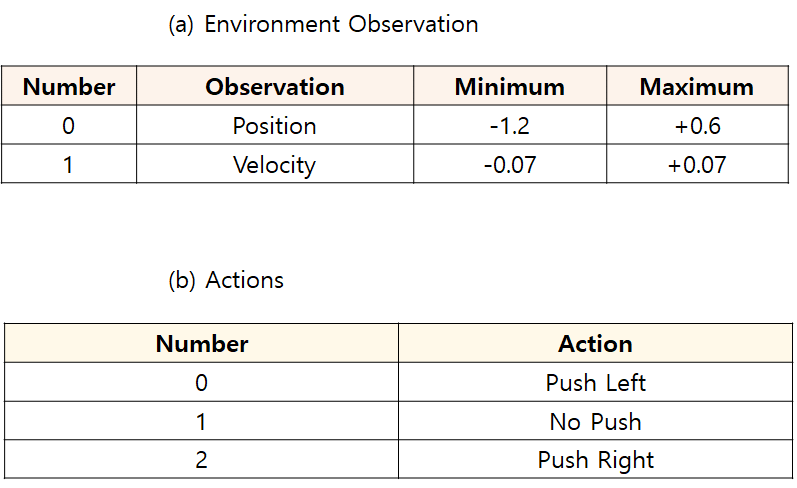

References:
- https://www.researchgate.net/figure/a-The-environment-of-MountainCar-V0-and-b-the-actions-taken-by-the-agent-of_fig6_336969606
- https://gym.openai.com/envs/MountainCar-v0/


In [22]:
class MountainCarRunner:
    def run_mountaincar(params):
        gym_environment_name = params['gym_environment_name']
        gamma = params['gamma']
        replay_memory_capacity = params['replay_memory_capacity']
        lr = params['lr']
        target_net_update_steps = params['target_net_update_steps']
        batch_size = params['batch_size']
        bad_state_penalty = params['bad_state_penalty']
        min_samples_for_training = params['min_samples_for_training']
        reward_function = params['reward_function']
        
        replay_mem = ReplayMemory(replay_memory_capacity) # Initialize the replay memory
        env, state_space_dim, action_space_dim = DeepQNetwork.get_gym_info(gym_environment_name) # Initialize the Gym environment
        policy_net = DeepQNetwork(state_space_dim, action_space_dim, params) # Initialize the policy network
        target_net = DeepQNetwork(state_space_dim, action_space_dim, params) # Initialize the target network with the same weights of the policy network
        target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

        optimizer = torch.optim.SGD(policy_net.parameters(), lr=lr) # Initialize the optimizer. The optimizer will update ONLY the parameters of the policy network

        loss_fn = nn.SmoothL1Loss() # Initialize the loss function (Huber loss)

        exploration_profile = DeepQNetwork.get_exploration_profile(params)

        maximum_score = float('-inf')
        episode_maximum_score = float('-inf')
        temperature_maximum_score = float('-inf')

        for episode_num, tau in enumerate(tqdm(exploration_profile)):
            state = env.reset() # Reset the environment and get the initial state
            score = 0 # Reset the score. The final score will be the total reward
            done = False

            while not done: # Go on until the pole falls off
                action, q_values = DeepQNetwork.choose_action_softmax(policy_net, state, temperature=tau) # Choose the action following the policy
                next_state, reward, done, info = env.step(action) # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
                
                reward = reward_function(reward, state)

                score += reward # Update the final score

                if done: # Apply penalty for bad state
                    reward += bad_state_penalty
                    next_state = None

                # Update the replay memory
                replay_mem.push(state, action, next_state, reward)

                # Update the network
                if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
                    DeepQNetwork.update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)

                if should_show_videos:
                    env.render() # Visually render the environment (disable to speed up the training)
                
                state = next_state # Set the current state for the next iteration

            if episode_num % target_net_update_steps == 0: # Update the target network every target_net_update_steps episodes
                print('Updating target network...')
                target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

            print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score
            
            if score > maximum_score:
                maximum_score = score
                episode_maximum_score = episode_num
                temperature_maximum_score = tau
        env.close()
        print(f"(Best) EPISODE: {episode_maximum_score} - FINAL SCORE: {maximum_score} - Temperature: {temperature_maximum_score}") # Print the final score
        return policy_net
    
    def validate_trained_model(policy_net, number_of_validation_episodes = 10):
        gym_environment_name = policy_net.params['gym_environment_name']
        env, _, _ = DeepQNetwork.get_gym_info(gym_environment_name) # Initialize the Gym environment

        for num_episode in range(number_of_validation_episodes):
            state = env.reset() # Reset the environment and get the initial state
            score = 0 # Reset the score. The final score will be 500 if achieved the goal, otherwise 0
            done = False
            
            while not done: # Go on until the pole falls off
                action, q_values = DeepQNetwork.choose_action_softmax(policy_net, state, temperature=0) # Choose the best action (temperature 0)
                next_state, reward, done, info = env.step(action) # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
                if should_show_videos:
                    env.render() # Visually render the environment
                
                #  Reward: Reward of 0 is awarded if the agent reached the flag
                #  (position = 0.5) on top of the mountain. Reward of -1 is awarded if the position of the agent is less than 0.5.
                score += reward # Update the final score
                state = next_state # Set the current state for the next iteration
                
            # Print the final score
            final_score = 500 if 200 + score > 0 else 0
            print(f"EPISODE {num_episode + 1} - FINAL SCORE: {final_score}") 
        env.close()

In [23]:
### PARAMETERS
params = {
    'gym_environment_name': 'MountainCar-v0',
    'gamma': 0.97,   # gamma parameter for the long term reward
    'replay_memory_capacity': 10000,   # Replay memory capacity
    'min_samples_for_training': 1000,   # Minimum samples in the replay memory to enable the training
    'lr': 2e-2,   # Optimizer learning rate
    'target_net_update_steps': 15,   # Number of episodes to wait before updating the target network
    'batch_size': 64,   # Number of samples to take from the replay memory for each update
    'bad_state_penalty': 0,   # Penalty to the reward when we are in a bad state 
    'exploration_profile__initial_temperature_value': 7,
    'exploration_profile__num_iterations': 500,
    'reward_function': lambda reward, state: (state[0] if state[0] < 0 else state[0] * 20) + 100 * abs(state[1])
}

torch.manual_seed(10)
policy_net = MountainCarRunner.run_mountaincar(params)

STATE SPACE SIZE: 2
ACTION SPACE SIZE: 3


  0%|          | 0/500 [00:00<?, ?it/s]

Updating target network...
EPISODE: 1 - FINAL SCORE: 33.695738412294304 - Temperature: 7.0
EPISODE: 2 - FINAL SCORE: 89.39165413303999 - Temperature: 6.838437208683303
EPISODE: 3 - FINAL SCORE: -2.805174135384732 - Temperature: 6.6806033510148985
EPISODE: 4 - FINAL SCORE: -43.903766593693945 - Temperature: 6.526412361719236
EPISODE: 5 - FINAL SCORE: 56.29268319832045 - Temperature: 6.375780161941643
EPISODE: 6 - FINAL SCORE: 21.94995506646228 - Temperature: 6.228624613400941
EPISODE: 7 - FINAL SCORE: -2.033575895246628 - Temperature: 6.084865473600236
EPISODE: 8 - FINAL SCORE: 3.9995008493133355 - Temperature: 5.944424352071458
EPISODE: 9 - FINAL SCORE: 75.80245531129185 - Temperature: 5.8072246676298
EPISODE: 10 - FINAL SCORE: -49.36568469018857 - Temperature: 5.673191606614736
EPISODE: 11 - FINAL SCORE: 55.27452014253504 - Temperature: 5.54225208209486
EPISODE: 12 - FINAL SCORE: 97.1797464856063 - Temperature: 5.414334694014286
EPISODE: 13 - FINAL SCORE: -58.95009038328499 - Temperat

In [24]:
should_show_videos = True
MountainCarRunner.validate_trained_model(policy_net, number_of_validation_episodes=10)
show_videos() # Display the videos, not required outside Colab
should_show_videos = False

STATE SPACE SIZE: 2
ACTION SPACE SIZE: 3
EPISODE 1 - FINAL SCORE: 500
EPISODE 2 - FINAL SCORE: 500
EPISODE 3 - FINAL SCORE: 500
EPISODE 4 - FINAL SCORE: 500
EPISODE 5 - FINAL SCORE: 500
EPISODE 6 - FINAL SCORE: 500
EPISODE 7 - FINAL SCORE: 500
EPISODE 8 - FINAL SCORE: 500
EPISODE 9 - FINAL SCORE: 500
EPISODE 10 - FINAL SCORE: 500
